In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import BRkNNaClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

#Read training data
train_data=pd.read_csv('train.csv')
train_data.head()

,LossDescription,ResultingInjuryDesc,PartInjuredDesc,Cause - Hierarchy 1,Body Part - Hierarchy 1,Index
0,EE while helping the children clean up after l...,Fall Or Slip Injury,Lower Extremities,"Fall, Slip or Trip Injury",Lower Extremities,577
1,Clmt was putting bread trays on bottom of brea...,NaN,NaN,Burn or Scald - Heat or Cold Exposures - Conta...,Neck,1867
2,He got off of he forklift and did not secure p...,"Motor Vehicle, NOC","Foot-Metatarsals, Heel excl Ankle or Toe",Motor Vehicle,Lower Extremities,3530
3,slammed left finger in closet,Struck Or Injured By,Upper Extremities,Struck or Injured by,Upper Extremities,583
4,the employee was digging a tre; strain; lower ...,NaN,NaN,Strain or Injury by,Trunk,1711


In [2]:
#Check shape
print(f'Number of rows:{train_data.shape[0]}')
print(f'Number of columns:{train_data.shape[1]}')

Number of rows:3918
Number of columns:6


In [3]:
#Check missing values
print(f'Missing values per column:\n{train_data.isnull().sum()}')

Missing values per column:
LossDescription              32
ResultingInjuryDesc        1429
PartInjuredDesc            1996
Cause - Hierarchy 1          26
Body Part - Hierarchy 1     259
Index                         0
dtype: int64


In [4]:
#Data types
print(f'Data Types:\n{train_data.dtypes}')

Data Types:
LossDescription            object
ResultingInjuryDesc        object
PartInjuredDesc            object
Cause - Hierarchy 1        object
Body Part - Hierarchy 1    object
Index                       int64
dtype: object


In [5]:
#Check unique values
print(f"Unique Values in 'Cause - Hierarchy 1':\n{train_data['Cause - Hierarchy 1'].value_counts()}")
print(f"Unique values in 'Body Part - Hierarchy 1':\n{train_data['Body Part - Hierarchy 1'].value_counts()}")

Unique Values in 'Cause - Hierarchy 1':
Cause - Hierarchy 1
Struck or Injured by                                     727
Strain or Injury by                                      715
Misc                                                     700
Fall, Slip or Trip Injury                                669
Cut, Puncture, Scrape Injured by                         444
Motor Vehicle                                            289
Striking Against or Stepping on                          143
Caught In, Under or Between                              101
Burn or Scald - Heat or Cold Exposures - Contact With     54
Rubbed or Abraded by                                      18
fall, Slip or Trip Injury                                 12
Includes Freezing                                         10
MIsc                                                       4
Fall, Slip, Or Trip Injury                                 3
Fall, slip, or trip injury                                 2
Strain Or Injury By      

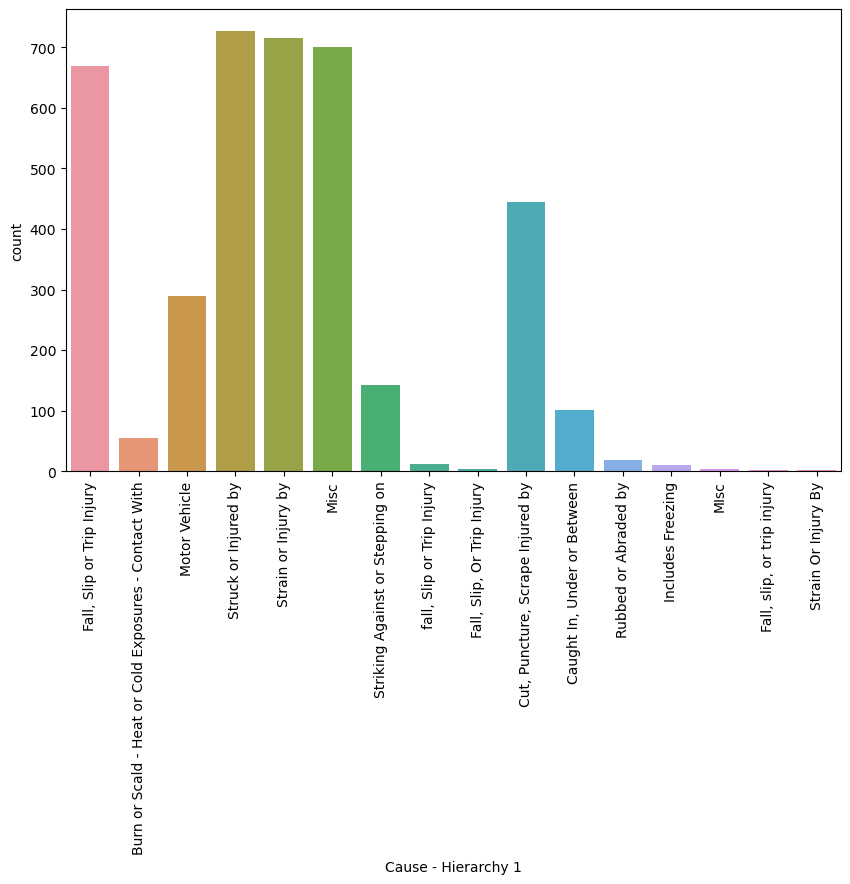

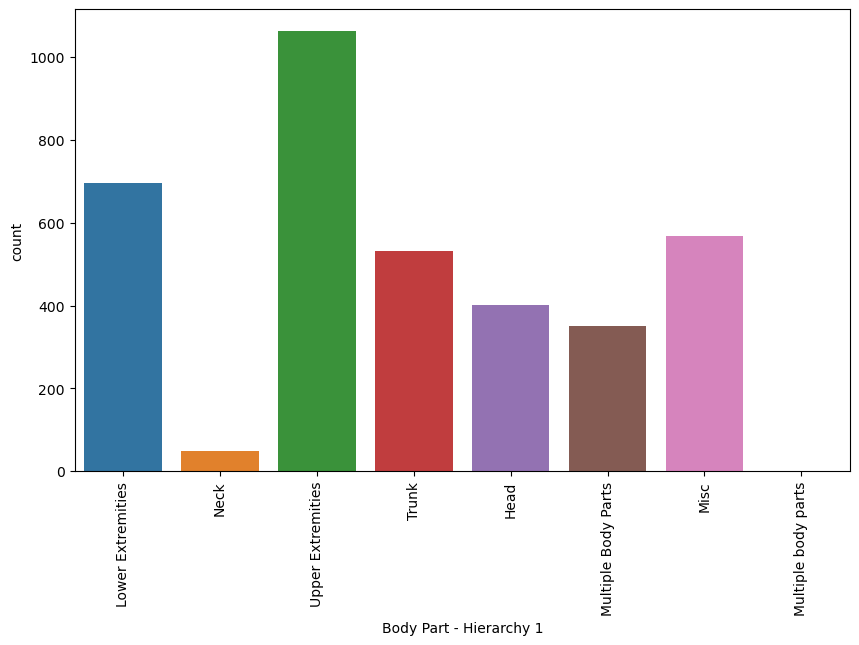

In [6]:
# Visualize target variable distributions
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='Cause - Hierarchy 1')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='Body Part - Hierarchy 1')
plt.xticks(rotation=90)
plt.show()

In [7]:
#Missing values filled with 'None'
train_data.fillna({'LossDescription':'None'}, inplace=True)
train_data.fillna({'ResultingInjuryDesc':'None'}, inplace=True)
train_data.fillna({'PartInjuredDesc':'None'}, inplace=True)
train_data.fillna({'Cause - Hierarchy 1':'None'}, inplace=True)
train_data.fillna({'Body Part - Hierarchy 1':'None'}, inplace=True)

In [8]:
#Check missing values
print(f'Missing values per column:\n{train_data.isnull().sum()}')

Missing values per column:
LossDescription            0
ResultingInjuryDesc        0
PartInjuredDesc            0
Cause - Hierarchy 1        0
Body Part - Hierarchy 1    0
Index                      0
dtype: int64


In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess text data
text_columns = ['LossDescription', 'ResultingInjuryDesc', 'PartInjuredDesc']
vectorizer = CountVectorizer()
text_data = vectorizer.fit_transform(train_data[text_columns].fillna('').apply(lambda x: ' '.join(x), axis=1))

In [10]:
# Encode categorical variables
label_encoder = LabelEncoder()
train_data['Cause - Hierarchy 1'] = label_encoder.fit_transform(train_data['Cause - Hierarchy 1'])
train_data['Body Part - Hierarchy 1'] = label_encoder.fit_transform(train_data['Body Part - Hierarchy 1'])

In [11]:
# Split data into training and validation sets
X_train, X_val, y_train_cause, y_val_cause, y_train_body, y_val_body = train_test_split(text_data, train_data['Cause - Hierarchy 1'], train_data['Body Part - Hierarchy 1'], test_size=0.2, random_state=42)

In [12]:
# Convert target variables to 2D NumPy arrays
mlb_cause = MultiLabelBinarizer()
mlb_body = MultiLabelBinarizer()
y_train_cause = mlb_cause.fit_transform(y_train_cause.values.reshape(-1, 1))
y_val_cause = mlb_cause.transform(y_val_cause.values.reshape(-1, 1))
y_train_body = mlb_body.fit_transform(y_train_body.values.reshape(-1, 1))
y_val_body = mlb_body.transform(y_val_body.values.reshape(-1, 1))

c:\Users\nikhi\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) [12] will be ignored
  warnings.warn(


In [13]:
# Train a Binary Relevance model for "Cause - Hierarchy 1"
classifier_cause = BinaryRelevance(LogisticRegression())
classifier_cause.fit(X_train, y_train_cause)

# Train a Binary Relevance model for "Body Part - Hierarchy 1"
classifier_body = BinaryRelevance(LogisticRegression())
classifier_body.fit(X_train, y_train_body)

BinaryRelevance(classifier=LogisticRegression(), require_dense=[True, True])

In [14]:
# Evaluate model for "Cause - Hierarchy 1 (by Binary Relevance)"
y_pred_cause = classifier_cause.predict(X_val)
accuracy_cause = accuracy_score(y_val_cause, y_pred_cause)
precision_cause = precision_score(y_val_cause, y_pred_cause, average='micro')
recall_cause = recall_score(y_val_cause, y_pred_cause, average='micro')
f1_cause = f1_score(y_val_cause, y_pred_cause, average='micro')

print('Cause - Hierarchy 1 Evaluation Metrics (by Binary Relevance):')
print(f'Accuracy: {accuracy_cause}')
print(f'Precision: {precision_cause}')
print(f'Recall: {recall_cause}')
print(f'F1-score: {f1_cause}')

# Evaluate model for "Body Part - Hierarchy 1 (by Binary Relevance)"
y_pred_body = classifier_body.predict(X_val)
accuracy_body = accuracy_score(y_val_body, y_pred_body)
precision_body = precision_score(y_val_body, y_pred_body, average='micro')
recall_body = recall_score(y_val_body, y_pred_body, average='micro')
f1_body = f1_score(y_val_body, y_pred_body, average='micro')

print('\nBody Part - Hierarchy 1 Evaluation Metrics (by Binary Relevance):')
print(f'Accuracy: {accuracy_body}')
print(f'Precision: {precision_body}')
print(f'Recall: {recall_body}')
print(f'F1-score: {f1_body}')

Cause - Hierarchy 1 Evaluation Metrics (by Binary Relevance):
Accuracy: 0.7602040816326531
Precision: 0.9099099099099099
Recall: 0.7739463601532567
F1-score: 0.8364389233954451

Body Part - Hierarchy 1 Evaluation Metrics (by Binary Relevance):
Accuracy: 0.8010204081632653
Precision: 0.9280575539568345
Recall: 0.8227040816326531
F1-score: 0.872210953346856


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

#Train a k-NN model with Multi-Output for Cause
knn_cause=MultiOutputClassifier(KNeighborsClassifier())
knn_cause.fit(X_train, y_train_cause)

#Train a k-NN model with Multi-Output for Body Part
knn_body=MultiOutputClassifier(KNeighborsClassifier())
knn_body.fit(X_train, y_train_body)

MultiOutputClassifier(estimator=KNeighborsClassifier())

In [16]:
# Evaluate model for "Cause - Hierarchy 1 (by KNN)"
y_pred_cause = knn_cause.predict(X_val)
accuracy_cause = accuracy_score(y_val_cause, y_pred_cause)
precision_cause = precision_score(y_val_cause, y_pred_cause, average='micro')
recall_cause = recall_score(y_val_cause, y_pred_cause, average='micro')
f1_cause = f1_score(y_val_cause, y_pred_cause, average='micro')

print('Cause - Hierarchy 1 Evaluation Metrics (by KNN):')
print(f'Accuracy: {accuracy_cause}')
print(f'Precision: {precision_cause}')
print(f'Recall: {recall_cause}')
print(f'F1-score: {f1_cause}')

# Evaluate model for "Body Part - Hierarchy 1 (by KNN)"
y_pred_body = knn_body.predict(X_val)
accuracy_body = accuracy_score(y_val_body, y_pred_body)
precision_body = precision_score(y_val_body, y_pred_body, average='micro')
recall_body = recall_score(y_val_body, y_pred_body, average='micro')
f1_body = f1_score(y_val_body, y_pred_body, average='micro')

print('\nBody Part - Hierarchy 1 Evaluation Metrics (by KNN):')
print(f'Accuracy: {accuracy_body}')
print(f'Precision: {precision_body}')
print(f'Recall: {recall_body}')
print(f'F1-score: {f1_body}')

Cause - Hierarchy 1 Evaluation Metrics (by KNN):
Accuracy: 0.6594387755102041
Precision: 0.8616666666666667
Recall: 0.6602809706257982
F1-score: 0.7476500361532898

Body Part - Hierarchy 1 Evaluation Metrics (by KNN):
Accuracy: 0.5408163265306123
Precision: 0.7895716945996276
Recall: 0.5408163265306123
F1-score: 0.6419379258137775


In [17]:
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression

#Train a Logistic Regression model with Classifier Chains for Cause
chain_cause=ClassifierChain(LogisticRegression(random_state=42))
chain_cause.fit(X_train,y_train_cause)

#Train a Logistic Regression model with Classifier  Chains for Body Part
chain_body=ClassifierChain(LogisticRegression(random_state=42))
chain_body.fit(X_train,y_train_body)

ClassifierChain(base_estimator=LogisticRegression(random_state=42))

In [18]:
# Evaluate model for "Cause - Hierarchy 1 (by Classifier Chain)"
y_pred_cause = chain_cause.predict(X_val)
accuracy_cause = accuracy_score(y_val_cause, y_pred_cause)
precision_cause = precision_score(y_val_cause, y_pred_cause, average='micro')
recall_cause = recall_score(y_val_cause, y_pred_cause, average='micro')
f1_cause = f1_score(y_val_cause, y_pred_cause, average='micro')

print('Cause - Hierarchy 1 Evaluation Metrics (by Classifier Chain):')
print(f'Accuracy: {accuracy_cause}')
print(f'Precision: {precision_cause}')
print(f'Recall: {recall_cause}')
print(f'F1-score: {f1_cause}')

# Evaluate model for "Body Part - Hierarchy 1 (by Classifier Chain)"
y_pred_body = chain_body.predict(X_val)
accuracy_body = accuracy_score(y_val_body, y_pred_body)
precision_body = precision_score(y_val_body, y_pred_body, average='micro')
recall_body = recall_score(y_val_body, y_pred_body, average='micro')
f1_body = f1_score(y_val_body, y_pred_body, average='micro')

print('\nBody Part - Hierarchy 1 Evaluation Metrics (by Classifier Chain):')
print(f'Accuracy: {accuracy_body}')
print(f'Precision: {precision_body}')
print(f'Recall: {recall_body}')
print(f'F1-score: {f1_body}')

Cause - Hierarchy 1 Evaluation Metrics (by Classifier Chain):
Accuracy: 0.8163265306122449
Precision: 0.8677462887989204
Recall: 0.8212005108556832
F1-score: 0.8438320209973754

Body Part - Hierarchy 1 Evaluation Metrics (by Classifier Chain):
Accuracy: 0.8418367346938775
Precision: 0.8710526315789474
Recall: 0.8443877551020408
F1-score: 0.8575129533678757


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

# Train model for "Cause - Hierarchy 1"
dtree_cause = MultiOutputClassifier(DecisionTreeClassifier())
dtree_cause.fit(X_train, y_train_cause)

# Train model for "Body Part - Hierarchy 1"
dtree_body = MultiOutputClassifier(DecisionTreeClassifier())
dtree_body.fit(X_train, y_train_body)

MultiOutputClassifier(estimator=DecisionTreeClassifier())

In [20]:
# Evaluate model for "Cause - Hierarchy 1 (by Decision Tree Classifier)"
y_pred_cause = dtree_cause.predict(X_val)
accuracy_cause = accuracy_score(y_val_cause, y_pred_cause)
precision_cause = precision_score(y_val_cause, y_pred_cause, average='micro')
recall_cause = recall_score(y_val_cause, y_pred_cause, average='micro')
f1_cause = f1_score(y_val_cause, y_pred_cause, average='micro')

print('Cause - Hierarchy 1 Evaluation Metrics (by Decision Tree Classifier):')
print(f'Accuracy: {accuracy_cause}')
print(f'Precision: {precision_cause}')
print(f'Recall: {recall_cause}')
print(f'F1-score: {f1_cause}')

# Evaluate model for "Body Part - Hierarchy 1 (by Decision Tree Classifier)"
y_pred_body = dtree_body.predict(X_val)
accuracy_body = accuracy_score(y_val_body, y_pred_body)
precision_body = precision_score(y_val_body, y_pred_body, average='micro')
recall_body = recall_score(y_val_body, y_pred_body, average='micro')
f1_body = f1_score(y_val_body, y_pred_body, average='micro')

print('\nBody Part - Hierarchy 1 Evaluation Metrics (by Decision Tree Classifier):')
print(f'Accuracy: {accuracy_body}')
print(f'Precision: {precision_body}')
print(f'Recall: {recall_body}')
print(f'F1-score: {f1_body}')

Cause - Hierarchy 1 Evaluation Metrics (by Decision Tree Classifier):
Accuracy: 0.7079081632653061
Precision: 0.8042929292929293
Recall: 0.8135376756066411
F1-score: 0.8088888888888889

Body Part - Hierarchy 1 Evaluation Metrics (by Decision Tree Classifier):
Accuracy: 0.7653061224489796
Precision: 0.8597168597168597
Recall: 0.8520408163265306
F1-score: 0.8558616271620757


In [21]:
#Preprocess for Neural Network
training_data=pd.read_csv('train.csv')

training_data.fillna({'LossDescription':'None'}, inplace=True)
training_data.fillna({'ResultingInjuryDesc':'None'}, inplace=True)
training_data.fillna({'PartInjuredDesc':'None'}, inplace=True)
training_data.fillna({'Cause - Hierarchy 1':'None'}, inplace=True)
training_data.fillna({'Body Part - Hierarchy 1':'None'}, inplace=True)

# Preprocess text data
text_columns = ['LossDescription', 'ResultingInjuryDesc', 'PartInjuredDesc']
vectorizer = CountVectorizer()
text_data = vectorizer.fit_transform(training_data[text_columns].fillna('').apply(lambda x: ' '.join(x), axis=1))
input_ids = text_data.toarray()  # Convert sparse matrix to dense NumPy array

# Encode categorical variables
label_encoder = LabelEncoder()
training_data['Cause - Hierarchy 1'] = label_encoder.fit_transform(training_data['Cause - Hierarchy 1'])
training_data['Body Part - Hierarchy 1'] = label_encoder.fit_transform(training_data['Body Part - Hierarchy 1'])

# Split data into training and validation sets
X_train, X_val, y_train_cause, y_val_cause, y_train_body, y_val_body = train_test_split(input_ids, training_data['Cause - Hierarchy 1'], training_data['Body Part - Hierarchy 1'], test_size=0.2, random_state=42)

# Convert target variables to 2D NumPy arrays
mlb_cause = MultiLabelBinarizer()
mlb_body = MultiLabelBinarizer()
y_train_cause = mlb_cause.fit_transform(y_train_cause.values.reshape(-1, 1))
y_val_cause = mlb_cause.transform(y_val_cause.values.reshape(-1, 1))
y_train_body = mlb_body.fit_transform(y_train_body.values.reshape(-1, 1))
y_val_body = mlb_body.transform(y_val_body.values.reshape(-1, 1))

c:\Users\nikhi\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) [12] will be ignored
  warnings.warn(


In [22]:
#Import necessary libraries
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import concatenate
from keras.optimizers import Adam

In [23]:
# Define input and output dimensions
input_dim = X_train.shape[1]
output_dim_cause = y_train_cause.shape[1]
output_dim_body = y_train_body.shape[1]

# Define the model architecture for "Cause - Hierarchy 1"
inputs = Input(shape=(input_dim,))
x = Dense(64, activation='relu')(inputs)
outputs_cause = Dense(output_dim_cause, activation='sigmoid')(x)
model_cause = Model(inputs=inputs, outputs=outputs_cause)

# Define the model architecture for "Body Part - Hierarchy 1"
inputs = Input(shape=(input_dim,))
x = Dense(64, activation='relu')(inputs)
outputs_body = Dense(output_dim_body, activation='sigmoid')(x)
model_body = Model(inputs=inputs, outputs=outputs_body)

# Compile the models
model_cause.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_body.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the models
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_cause.fit(X_train, y_train_cause, epochs=50, batch_size=32, validation_data=(X_val, y_val_cause), callbacks=[early_stopping])
model_body.fit(X_train, y_train_body, epochs=50, batch_size=32, validation_data=(X_val, y_val_body), callbacks=[early_stopping])

Epoch 1/50
98/98 [==============================] - 2s 7ms/step - loss: 0.3732 - accuracy: 0.3877 - val_loss: 0.1736 - val_accuracy: 0.6735
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1291 - accuracy: 0.7652 - val_loss: 0.1055 - val_accuracy: 0.7844
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0809 - accuracy: 0.8411 - val_loss: 0.0797 - val_accuracy: 0.8163
Epoch 4/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0581 - accuracy: 0.8803 - val_loss: 0.0682 - val_accuracy: 0.8316
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0450 - accuracy: 0.9123 - val_loss: 0.0626 - val_accuracy: 0.8367
Epoch 6/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0365 - accuracy: 0.9324 - val_loss: 0.0594 - val_accuracy: 0.8406
Epoch 7/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0304 - accuracy: 0.9435 - val_loss: 0.0579 - val_accuracy: 0.8393
Epoch 8/50
98/98 [==

In [24]:
# Evaluate the neural network model
_, accuracy_cause = model_cause.evaluate(X_val, y_val_cause)
_, accuracy_body = model_body.evaluate(X_val, y_val_body)

y_pred_cause = model_cause.predict(X_val)
y_pred_body = model_body.predict(X_val)

precision_cause = precision_score(y_val_cause, y_pred_cause.round(), average='micro')
recall_cause = recall_score(y_val_cause, y_pred_cause.round(), average='micro')
f1_cause = f1_score(y_val_cause, y_pred_cause.round(), average='micro')

precision_body = precision_score(y_val_body, y_pred_body.round(), average='micro')
recall_body = recall_score(y_val_body, y_pred_body.round(), average='micro')
f1_body = f1_score(y_val_body, y_pred_body.round(), average='micro')

print('Cause - Hierarchy 1 Metrics (Neural Network):')
print(f'Accuracy: {accuracy_cause}')
print(f'Precision: {precision_cause}')
print(f'Recall: {recall_cause}')
print(f'F1-score: {f1_cause}')

print('\nBody Part - Hierarchy 1 Metrics (Neural Network):')
print(f'Accuracy: {accuracy_body}')
print(f'Precision: {precision_body}')
print(f'Recall: {recall_body}')
print(f'F1-score: {f1_body}')

25/25 [==============================] - 0s 2ms/step
Cause - Hierarchy 1 Metrics (Neural Network):
Accuracy: 0.8418367505073547
Precision: 0.91350531107739
Recall: 0.768837803320562
F1-score: 0.8349514563106797

Body Part - Hierarchy 1 Metrics (Neural Network):
Accuracy: 0.8852040767669678
Precision: 0.9359534206695779
Recall: 0.8201530612244898
F1-score: 0.8742352141400408


In [25]:
#For predictions
test_data = pd.read_csv('test.csv')

#Replace NaN values with 'None'
test_data.fillna({'LossDescription':'None'}, inplace=True)
test_data.fillna({'ResultingInjuryDesc':'None'}, inplace=True)
test_data.fillna({'PartInjuredDesc':'None'}, inplace=True)
test_data.fillna({'Cause - Hierarchy 1':'None'}, inplace=True)
test_data.fillna({'Body Part - Hierarchy 1':'None'}, inplace=True)

text_columns = ['LossDescription', 'ResultingInjuryDesc', 'PartInjuredDesc']
test_text_data = vectorizer.transform(test_data[text_columns].fillna('').apply(lambda x: ' '.join(x), axis=1))

In [35]:
# Get the original label strings for 'Cause - Hierarchy 1' and 'Body Part - Hierarchy 1'
cause_labels = train_data['Cause - Hierarchy 1'].unique()
body_part_labels = train_data['Body Part - Hierarchy 1'].unique()

# Create dictionaries to map indices to label strings for 'Cause - Hierarchy 1' and 'Body Part - Hierarchy 1'
cause_label_mapping = {i: label for i, label in enumerate(cause_labels)}
body_part_label_mapping = {i: label for i, label in enumerate(body_part_labels)}

# Predict labels for 'Cause - Hierarchy 1' using Binary Relevance
test_pred_cause_labels = []
for sample in test_text_data:
    sample_array = sample.toarray()  # Convert sparse matrix to 2D NumPy array
    predictions_cause = classifier_cause.predict(sample_array)
    predictions_cause_array = predictions_cause.toarray()[0]
    test_pred_cause_labels.append([cause_label_mapping[idx] for idx, val in enumerate(predictions_cause_array) if val == 1])

# Predict labels for 'Body Part - Hierarchy 1' using Neural Network
test_pred_body_labels = []
for sample in test_text_data:
    sample_array = sample.toarray()  # Convert sparse matrix to 2D NumPy array
    predictions_body = model_body.predict(sample_array)
    predictions_body_array = predictions_body[0]
    test_pred_body_labels.append([body_part_label_mapping[idx] for idx, val in enumerate(predictions_body_array) if val > 0.5])

# Create the result DataFrame and save it to a CSV file
result_df = pd.DataFrame({
    'LossDescription': test_data['LossDescription'],
    'ResultingInjuryDesc': test_data['ResultingInjuryDesc'],
    'PartInjuredDesc': test_data['PartInjuredDesc'],
    'Predicted Cause - Hierarchy 1': test_pred_cause_labels,
    'Predicted Body Part - Hierarchy 1': test_pred_body_labels,
    'Index': test_data.index
})

result_df.to_csv('predictions.csv', index=False)

1/1 [==============================] - 0s 36ms/step


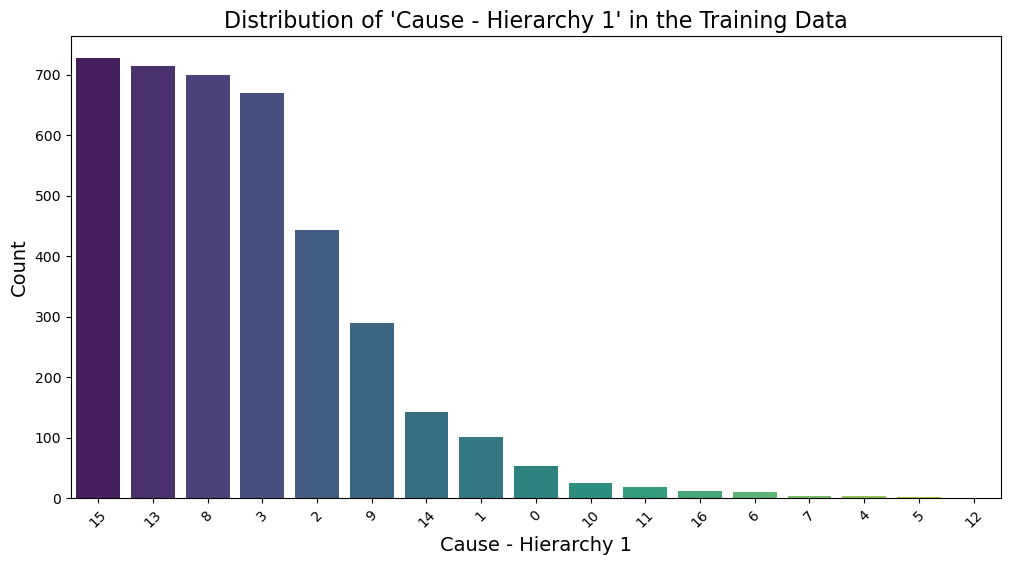

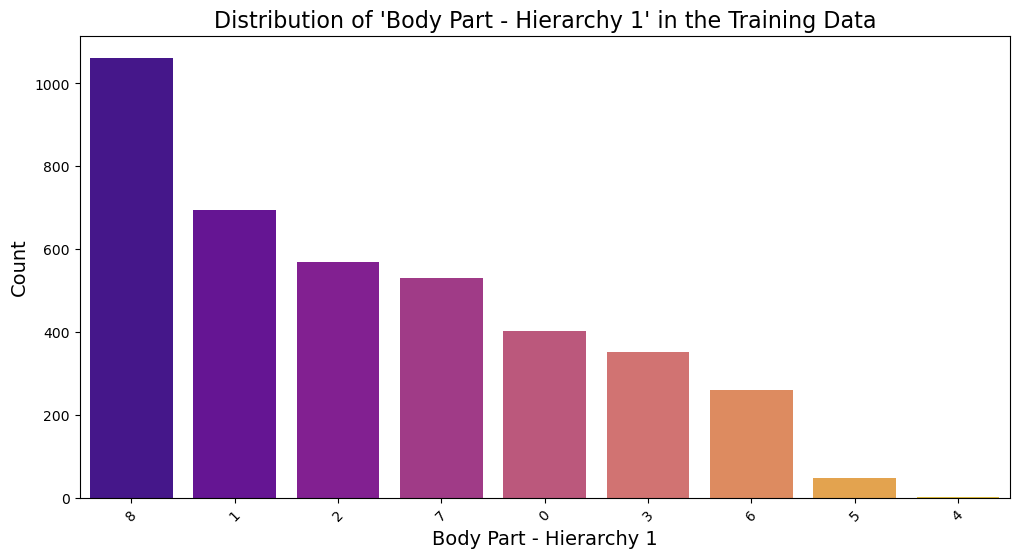

In [27]:
# Distribution of 'Cause - Hierarchy 1' in the training data
plt.figure(figsize=(12, 6))
sns.countplot(x="Cause - Hierarchy 1", data=training_data, order=training_data["Cause - Hierarchy 1"].value_counts().index, palette="viridis")
plt.title("Distribution of 'Cause - Hierarchy 1' in the Training Data", fontsize=16)
plt.xlabel("Cause - Hierarchy 1", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Distribution of 'Body Part - Hierarchy 1' in the training data
plt.figure(figsize=(12, 6))
sns.countplot(x="Body Part - Hierarchy 1", data=training_data, order=training_data["Body Part - Hierarchy 1"].value_counts().index, palette="plasma")
plt.title("Distribution of 'Body Part - Hierarchy 1' in the Training Data", fontsize=16)
plt.xlabel("Body Part - Hierarchy 1", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.show()